# Assignment 5

**Deadline**: March 7, 9pm

**Late Penalty**: See Syllabus

**TA**: Kingsley Chang

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code and outputs. Do not submit any other files produced by your code.

Completing this assignment using Jupyter Notebook is recommended (though not necessarily for all subsequent assignments). If you are using Jupyter Notebook, you can export a PDF file using the menu option File -> Download As -> PDF via LaTeX (pdf)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

## Part 1. Data Cleaning [12 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection
    
Download and unzip the Data Folder, and move the file `SMSSpamCollection` to your
working directory. (Same folder as this notebook)

### Part (a) [1 pt]

Open up the file in Python. Print out one example of a spam SMS, and one example of a non-spam SMS.

In [2]:
c = 0
for line in open('SMSSpamCollection'):
    if c >1:
        break
    if line[0] == 'h' and c == 0:
        print(line)
        c+=1
    elif line[0] == 's':
        print(line)
        c+=1

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



### Part (b) [1 pt]

How many spam messages and non-spam messages are there in the data set?

In [3]:
cs = 0
ch = 0
for line in open('SMSSpamCollection'):
    if line[0] == 's':
        cs+=1
    elif line[0] == 'h':
        ch+=1
print(cs)
print(ch)

747
4827


### Part (c) [2 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

One major difference is that we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify one advantage and one disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

    One advantage is that using character level modeling will result in the ability to identify misspelling in sentences. If we are using word level idenfication, there won't be a weight for the misspelled word. 

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

In [4]:
import torchtext

text_field = torchtext.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.data.TabularDataset("SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)
# dataset[0].sms
# dataset[0].label

# train, valid, test =  ...
train, valid, test = dataset.split(split_ratio=[0.6,0.2,0.2])

### Part (e) [2 pt]

You saw in part (b) that there are much more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.

We can fix this disparity by duplicating non-spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [5]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

    Having a balanced training set would prevent the wieght to be over dependent on certain features. Therefore, having a more balance training set would prevent this from happening and limit the use of weight balancing method. 

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [6]:
text_field.build_vocab(train)
#text_field.vocab.stoi
#text_field.vocab.itos

       text_field.vocab.stoi is used to find the corresponding index given a character. 
       text_field.vocab.itos is used to find the corresponding character given index.

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

    pad_token – The string token used as padding. Default: “<pad>”.
    unk_token – The string token used to represent Out Of Vocabulary words. Default: “<unk>”.

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at ~10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the ~10
batches?

In [7]:
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=True)                   # repeat the iterator for multiple epochs

In [23]:
for i, batch in enumerate(train_iter):
    if i >= 10:
        break
    count = 0
    maxLen = batch.sms[0].shape[1]
    print("Max Length is: ", maxLen)
    for i in batch.sms[1]:
        count += maxLen - int(i)
    print("Number of padding is: ", count)
    
    #print(batch.label)

Max Length is:  143
Number of padding is:  29
Max Length is:  160
Number of padding is:  0
Max Length is:  22
Number of padding is:  0
Max Length is:  54
Number of padding is:  23
Max Length is:  158
Number of padding is:  0
Max Length is:  49
Number of padding is:  14
Max Length is:  156
Number of padding is:  0
Max Length is:  138
Number of padding is:  15
Max Length is:  95
Number of padding is:  29
Max Length is:  146
Number of padding is:  12


## Part 2. Model Building [10 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN` or `nn.LSTM` module, and `self.fc` is a linear
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice.

In [9]:
# You mind find this code helpful for obtaining
# pytorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [10]:
class SpamDetector(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_classes):
        super(SpamDetector, self).__init__()
        # RNN attributes
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.n_class = num_classes
        # identiy matrix for generating one-hot vectors
        self.ident = torch.eye(vocab_size)
        # recurrent neural network
        self.rnn = nn.RNN(vocab_size, hidden_size, num_classes, batch_first=True)
        # a fully-connect layer that decodes the RNN output to
        # a distribution over the vocabulary
        self.decoder = nn.Linear(hidden_size, num_classes)
    
    def forward(self, inp):
        # reshape the input tensor to [1, seq_length]
        #inp = inp.view(1, -1)
        
        # generate one-hot vectors from token indices
        inp = self.ident[inp]
        h0 = torch.zeros(self.n_class, inp.size(0), self.hidden_size)
        #h0 = torch.zeros(self.n_class, 1, self.hidden_size)
        # obtain the next output and hidden state
        output, _ = self.rnn(inp,h0)
        # run the decoder
        output = self.decoder(torch.max(output, dim=1)[0])
        return output

    #def init_hidden(self):
     #   return torch.zeros(self.n_class, 1, self.hidden_size)

In [11]:
# This code is here to help you test your model.
# You may beed to change this depending on how your forward
# function is set up.

model = SpamDetector(len(text_field.vocab),20,2)
sample_batch = next(iter(train_iter))
sms = sample_batch.sms[0]
length = sample_batch.sms[1]
y = model(sms)
print(y.shape)

torch.Size([32, 2])


## Part 3. Training [15 pt]

### Part (a) [8 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically. You can use the following code to
compute your accuracy.


In [12]:
def get_accuracy(model, data):
    data_iter = torchtext.data.BucketIterator(data, 
                                              batch_size=64, 
                                              sort_key=lambda x: len(x.sms), 
                                              repeat=False)
    correct, total = 0, 0
    for i, batch in enumerate(data_iter):
        output = model(batch.sms[0]) # You may need to modify this, depending on your model setup
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(batch.label.view_as(pred)).sum().item()
        total += batch.sms[1].shape[0]
    return correct / total

In [13]:
def train_rnn_network(model, num_epochs=5, BS=64,learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    
    train_it = torchtext.data.BucketIterator(train, 
                                              batch_size=BS, 
                                              sort_key=lambda x: len(x.sms), 
                                              repeat=False)
    
    valid_it = torchtext.data.BucketIterator(valid, 
                                              batch_size=BS, 
                                              sort_key=lambda x: len(x.sms), 
                                              repeat=False)
    start_time = time.time()
    for epoch in range(num_epochs):
        for i, batch in enumerate(train_it):
            
            optimizer.zero_grad()
            output = model(batch.sms[0])
            loss = criterion(output, batch.label)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train))
        valid_acc.append(get_accuracy(model, valid))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
    
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

### Part (b) [5 pt]

Choose at least 4 hyper parameters to tune. Explain how you tuned the hyper parameters.
You don't need to include your traing curve for every model you trained.
Instead, explain what hyper paremters you tuned, what the validation accuracy was,
and the reasoning behind the hyper parameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyper parameters that are unrelated to the optimizer.

### First Training model
The first model referenced the model established in class. As 20 hidden layers are used to build the model. The learning rate of the model is increased from the default value to 0.0001 and the num_epoches is also increased for the relatively low learning rate. The batches size remained the same as default for this case. 

Epoch 1; Loss 0.676908; Train Acc 0.671231; Val Acc 0.883408
Epoch 2; Loss 0.659588; Train Acc 0.779429; Val Acc 0.594619
Epoch 3; Loss 0.643108; Train Acc 0.875438; Val Acc 0.791928
Epoch 4; Loss 0.578816; Train Acc 0.926866; Val Acc 0.943498
Epoch 5; Loss 0.434888; Train Acc 0.918350; Val Acc 0.951570
Epoch 6; Loss 0.303540; Train Acc 0.921356; Val Acc 0.897758
Epoch 7; Loss 0.241179; Train Acc 0.944899; Val Acc 0.939910
Epoch 8; Loss 0.177910; Train Acc 0.950910; Val Acc 0.946188
Epoch 9; Loss 0.206907; Train Acc 0.950910; Val Acc 0.929148
Epoch 10; Loss 0.156451; Train Acc 0.952079; Val Acc 0.957848
Epoch 11; Loss 0.255049; Train Acc 0.960761; Val Acc 0.942601
Epoch 12; Loss 0.125195; Train Acc 0.963934; Val Acc 0.932735
Epoch 13; Loss 0.135225; Train Acc 0.962264; Val Acc 0.947982
Epoch 14; Loss 0.195397; Train Acc 0.962097; Val Acc 0.929148
Epoch 15; Loss 0.166576; Train Acc 0.966605; Val Acc 0.939910
Epoch 16; Loss 0.219082; Train Acc 0.966105; Val Acc 0.952466
Epoch 17; Loss 0.

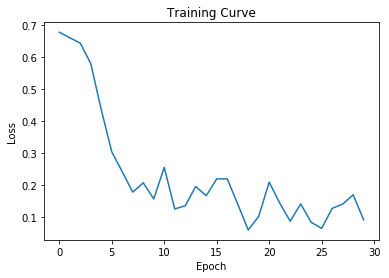

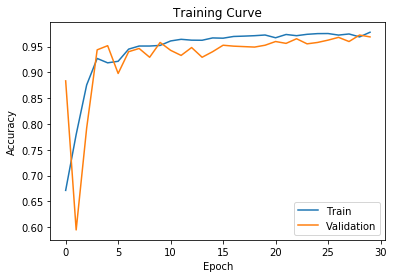

In [14]:
m1 = SpamDetector(len(text_field.vocab),20,2)
train_rnn_network(m1, learning_rate = 0.0001, num_epochs = 30)

### Second Training Model

As shown above, the result of the model seems to meet expectations. Now I want to explore the effect of changing the number of hidden layers of the model. I would expect that the time for this model to train will increase from the one we had above.

Epoch 1; Loss 0.650981; Train Acc 0.574720; Val Acc 0.231390
Epoch 2; Loss 0.274388; Train Acc 0.923860; Val Acc 0.953363
Epoch 3; Loss 0.163808; Train Acc 0.938220; Val Acc 0.939910
Epoch 4; Loss 0.137275; Train Acc 0.928870; Val Acc 0.890583
Epoch 5; Loss 0.133834; Train Acc 0.946736; Val Acc 0.942601
Epoch 6; Loss 0.145344; Train Acc 0.948906; Val Acc 0.948879
Epoch 7; Loss 0.111269; Train Acc 0.954583; Val Acc 0.947085
Epoch 8; Loss 0.090212; Train Acc 0.955585; Val Acc 0.953363
Epoch 9; Loss 0.150310; Train Acc 0.934547; Val Acc 0.889686
Epoch 10; Loss 0.055158; Train Acc 0.966271; Val Acc 0.957848
Epoch 11; Loss 0.156747; Train Acc 0.969945; Val Acc 0.968610
Epoch 12; Loss 0.083862; Train Acc 0.970613; Val Acc 0.967713
Epoch 13; Loss 0.047743; Train Acc 0.970780; Val Acc 0.965022
Epoch 14; Loss 0.123916; Train Acc 0.976791; Val Acc 0.973991
Epoch 15; Loss 0.097232; Train Acc 0.976958; Val Acc 0.972197
Epoch 16; Loss 0.130762; Train Acc 0.975956; Val Acc 0.973991
Epoch 17; Loss 0.

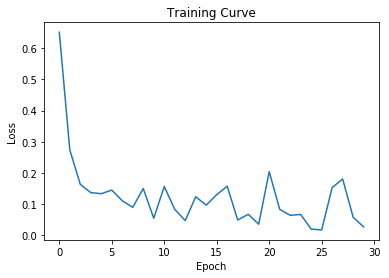

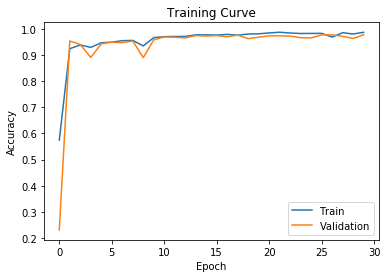

In [15]:
m2 = SpamDetector(len(text_field.vocab),80,2)
train_rnn_network(m2, learning_rate = 0.0001, num_epochs = 30)

### Third Training Model

As seem from the training curve above, more hidden layer in this case resulted in increase in noise give similar parameters. In order to decrease the noise of the model, I have increased the batch size for the third model. This model might take longer, therfore I am decreasing the number of epochs to 20. However, this action may cause the model to overfit to the data

Epoch 1; Loss 0.666306; Train Acc 0.523961; Val Acc 0.142601
Epoch 2; Loss 0.627660; Train Acc 0.930706; Val Acc 0.881614
Epoch 3; Loss 0.444529; Train Acc 0.932209; Val Acc 0.932735
Epoch 4; Loss 0.295445; Train Acc 0.935048; Val Acc 0.914798
Epoch 5; Loss 0.885941; Train Acc 0.515445; Val Acc 0.130045
Epoch 6; Loss 0.588948; Train Acc 0.910169; Val Acc 0.926457
Epoch 7; Loss 0.564798; Train Acc 0.782601; Val Acc 0.919283
Epoch 8; Loss 0.507522; Train Acc 0.725831; Val Acc 0.910314
Epoch 9; Loss 0.640863; Train Acc 0.759392; Val Acc 0.938117
Epoch 10; Loss 0.416823; Train Acc 0.838704; Val Acc 0.951570
Epoch 11; Loss 0.470188; Train Acc 0.858073; Val Acc 0.957848
Epoch 12; Loss 0.311932; Train Acc 0.896477; Val Acc 0.958744
Epoch 13; Loss 0.308885; Train Acc 0.902822; Val Acc 0.959641
Epoch 14; Loss 0.305090; Train Acc 0.905326; Val Acc 0.960538
Epoch 15; Loss 0.283414; Train Acc 0.908499; Val Acc 0.960538
Epoch 16; Loss 0.304938; Train Acc 0.914510; Val Acc 0.960538
Epoch 17; Loss 0.

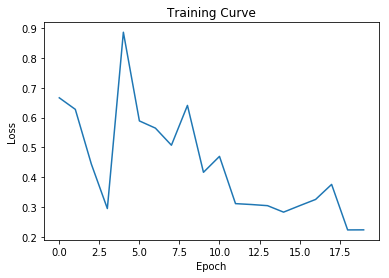

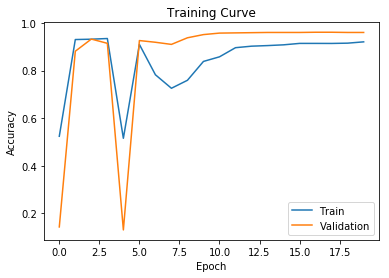

In [16]:
m3 = SpamDetector(len(text_field.vocab),80,2)
train_rnn_network(m3, learning_rate = 0.0001, num_epochs = 20, BS = 128)

### Part (c) [2 pt]

Report the final test accuracy of your model. You should be able to obtain fairly good accuracy for this model.

In [21]:
acc = get_accuracy(m2, test)
print(acc)

0.9766606822262118


## Part 4. Baseline Model [3 pt]

Do you think detecting spam is an easy or difficult task?
One way to answer this question is to think of a **baseline model**: a simple
model that is easy to build and inexpensive to run, that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models.

For the purpose of this lab, a spam detector could be implemented by using detection of common words. For example, most of the words in spam messages could include FREE, PROMO or SALES. By making an algrothism to count the number of these words present in the message could be a baseline model for the spam detection model. 

This model does not require training and would be very cost effective for evaluation purposes.